## <center>ANN Classification </center>

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("C:/Users/Lenovo/Desktop/Python/Neural Networks/Data Sets/PyTorch/NYCTaxiFares.csv")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [3]:
df['fare_class'].value_counts()

0    80000
1    40000
Name: fare_class, dtype: int64

Conveniently, 2/3 of the data have fares under $10, and 1/3 have fares $10 and above.

Fare classes correspond to fare amounts as follows:
<table style="display: inline-block">
<tr><th>Class</th><th>Values</th></tr>
<tr><td>0</td><td>< \$10.00</td></tr>
<tr><td>1</td><td>>= \$10.00</td></tr>
</table>

### Performing the same data adjustments to the data frame

In [4]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [5]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [6]:
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm,Fri


In [7]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
y_col = ['fare_class']  # this column contains the labels

In [8]:
# Convert our three categorical columns to category dtypes.
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [9]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

cats = np.stack([hr, ampm, wkdy], 1)

cats[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

In [10]:
# Convert categorical variables to a tensor
cats = torch.tensor(cats, dtype=torch.int64)
# this syntax is ok, since the source data is an array, not an existing tensor

cats[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

In [11]:
# Convert continuous variables to a tensor
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   2.1263],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   1.3923],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   3.3268],
        [ 40.7564, -73.9905,  40.7482, -73.9712,   1.0000,   1.8641],
        [ 40.7342, -73.9910,  40.7431, -73.9060,   1.0000,   7.2313]])

Note: the CrossEntropyLoss function we'll use below expects a 1d y-tensor, so we'll replace <tt>.reshape(-1,1)</tt> with <tt>.flatten()</tt> this time.

In [13]:
# Convert labels to a tensor
y = torch.tensor(df[y_col].values).flatten()
y

tensor([0, 0, 1,  ..., 1, 0, 0])

In [14]:
cats.shape, conts.shape, y.shape

(torch.Size([120000, 3]), torch.Size([120000, 6]), torch.Size([120000]))

In [15]:
# This will set embedding sizes for Hours, AMvsPM and Weekdays
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

<div class="alert alert-danger"><strong>This is how the categorical embeddings are passed into the layers.</strong></div>

In [16]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [17]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 2, [200,100], p=0.4) # out_sz = 2
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

### Define loss function & optimizer
For our classification we'll replace the MSE loss function with <a href='https://pytorch.org/docs/stable/nn.html#crossentropyloss'><strong><tt>torch.nn.CrossEntropyLoss()</tt></strong></a><br>
For the optimizer, we'll continue to use <a href='https://pytorch.org/docs/stable/optim.html#torch.optim.Adam'><strong><tt>torch.optim.Adam()</tt></strong></a>

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Perform train/test splits
At this point our batch size is the entire dataset of 120,000 records. To save time we'll use the first 60,000. Recall that our tensors are already randomly shuffled.

In [19]:
batch_size = 60000
test_size = 12000

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [20]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%50 == 0:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  50  loss: 0.36138177
epoch: 100  loss: 0.30084622
epoch: 150  loss: 0.28215519
epoch: 200  loss: 0.27397943
epoch: 250  loss: 0.26835245
epoch: 300  loss: 0.25954741
epoch: 300  loss: 0.25954741

Duration: 929 seconds


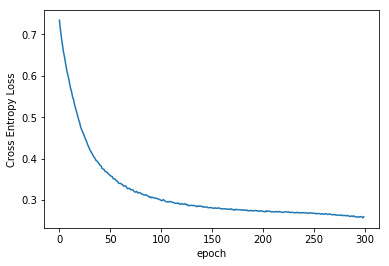

In [21]:
plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

## Validate the model

In [22]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = criterion(y_val, y_test)
print(f'CE Loss: {loss:.8f}')

CE Loss: 0.25455907


Now let's look at the first 50 predicted values

In [23]:
rows = 50
correct = 0
print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_test[i]:^7}')
    if y_val[i].argmax().item() == y_test[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')

MODEL OUTPUT               ARGMAX  Y_TEST
tensor([ 1.8121, -1.6474])    0      0   
tensor([-1.8144,  2.6326])    1      0   
tensor([ 1.4078, -1.9117])    0      0   
tensor([-1.9168,  1.4971])    1      1   
tensor([ 1.1824, -2.5137])    0      0   
tensor([ 2.1017, -2.3076])    0      0   
tensor([ 1.3294, -1.8394])    0      0   
tensor([-1.6212,  2.3970])    1      1   
tensor([ 2.2579, -2.4301])    0      0   
tensor([-0.4429,  1.1368])    1      1   
tensor([ 1.5110, -2.1682])    0      0   
tensor([ 0.7781, -1.9441])    0      0   
tensor([ 0.9649, -1.3784])    0      0   
tensor([-1.3647,  1.7324])    1      1   
tensor([ 1.4247, -2.4585])    0      0   
tensor([-1.4433,  2.6084])    1      1   
tensor([ 2.2743, -2.5698])    0      1   
tensor([ 1.4536, -2.7874])    0      0   
tensor([ 0.3212, -0.8780])    0      0   
tensor([ 2.0444, -1.9693])    0      0   
tensor([-1.3636,  2.1997])    1      1   
tensor([-0.4701,  0.3024])    1      1   
tensor([-2.0561,  2.2832])    1   